# General Imports

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
%matplotlib inline

In [3]:
from collections import namedtuple
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import seaborn as sns
from PIL import Image
from icecream import ic

In [4]:
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from torchvision import transforms as transform_lib
from pytorch_lightning.callbacks import TQDMProgressBar
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

In [5]:
from datasets import GtsrbModule

In [6]:
from pl_bolts.datamodules import CIFAR10DataModule
from pl_bolts.datamodules import STL10DataModule

In [7]:
from models import ResnetModule

In [8]:
from dropblock import DropBlock2D, LinearScheduler

In [9]:
from ls_ood_detect_cea.uncertainty_estimation import Hook
from ls_ood_detect_cea.uncertainty_estimation import deeplabv3p_get_ls_mcd_samples
from ls_ood_detect_cea.uncertainty_estimation import get_latent_represent_mcd_samples
from ls_ood_detect_cea.uncertainty_estimation import get_dl_h_z
from ls_ood_detect_cea.ood_detection_dataset import build_ood_detection_ds
from ls_ood_detect_cea.dimensionality_reduction import plot_samples_pacmap
from ls_ood_detect_cea.detectors import KDEClassifier
from ls_ood_detect_cea.metrics import get_ood_detector_results, plot_roc_ood_detector

# Paths

Datasets paths:

In [10]:
gtsrb_dataset_path = "/media/farnez/Data/DATASETS/gtsrb-data/"
cifar10_data_path = "/media/farnez/Data/DATASETS/cifar-10/"
stl10_data_path = "/media/farnez/Data/DATASETS/stl-10/"

Experiments path:

In [11]:
exp_path = "/media/farnez/Data/EXPERIMENTS/ICLR-2024/gtsrb-classification/"

Resnet Classification Model Number & checkpoint:

In [12]:
exp_model_name = "resnet18_model_7"

In [13]:
# gtsrb_resnet18_model_path = exp_path + exp_model_name + "/model/last.ckpt"
gtsrb_resnet18_model_path = exp_path + exp_model_name + "/model/epoch=1035-step=145040.ckpt"
gtsrb_resnet18_model_path

'/media/farnez/Data/EXPERIMENTS/ICLR-2024/gtsrb-classification/resnet18_model_7/model/epoch=1035-step=145040.ckpt'

Samples Paths:

In [14]:
mc_samples_path = exp_path + exp_model_name + "/embeddings_z/mc_samples/"
mc_samples_path

'/media/farnez/Data/EXPERIMENTS/ICLR-2024/gtsrb-classification/resnet18_model_7/embeddings_z/mc_samples/'

In [15]:
h_z_path = exp_path + exp_model_name + "/embeddings_z/entropy/"
h_z_path

'/media/farnez/Data/EXPERIMENTS/ICLR-2024/gtsrb-classification/resnet18_model_7/embeddings_z/entropy/'

# Compute Device

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Datasets

## GTSRB-Normal

In [17]:
gtsrb_normal_dm = GtsrbModule(img_size=(128, 128), data_path=gtsrb_dataset_path, batch_size=1, shuffle=False)

In [18]:
gtsrb_normal_dm.setup(stage='fit')
gtsrb_normal_dm.setup(stage='validate')
gtsrb_normal_dm.setup(stage='test')

In [19]:
gtsrb_ds_len = len(gtsrb_normal_dm.ds_gtsrb_train)
indices_train_dl = list(range(gtsrb_ds_len))
samples_size = 0.2 # of the dataset

random.seed(9290)
random.shuffle(indices_train_dl)

split = int(np.floor(gtsrb_ds_len * samples_size))
samples_idx = indices_train_dl[:split]
ic(len(samples_idx));

train_sampler = SubsetRandomSampler(samples_idx)

gtsrb_normal_dm.shuffle = False
gtsrb_normal_dm.ds_gtsrb_train_sampler = train_sampler

ic| len(samples_idx): 7120


In [20]:
gtsrb_normal_train_loader = gtsrb_normal_dm.train_dataloader()
gtsrb_normal_valid_loader = gtsrb_normal_dm.val_dataloader()
gtsrb_normal_test_loader = gtsrb_normal_dm.test_dataloader()
ic(len(gtsrb_normal_train_loader));
ic(len(gtsrb_normal_valid_loader));
ic(len(gtsrb_normal_test_loader));

ic| len(gtsrb_normal_train_loader): 7120
ic| len(gtsrb_normal_valid_loader): 3609


ic| len(gtsrb_normal_test_loader): 1273


In [21]:
dataiter = iter(gtsrb_normal_train_loader)

Speed limit (50km/h)


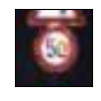

In [23]:
samp, lbl = dataiter.next()
lbl_np = lbl[0].cpu().numpy()
print(gtsrb_normal_dm.idx2label[lbl_np.item()])
gtsrb_normal_dm.unprocess_image(samp[0], plot=True)

## GTSRB-Anomalies

In [24]:
gtsrb_anomal_dm = GtsrbModule(img_size=(128, 128), data_path=gtsrb_dataset_path, batch_size=1, anomaly_transforms=True, shuffle=True)

In [25]:
gtsrb_anomal_dm.setup(stage='fit')
gtsrb_anomal_dm.setup(stage='validate')
gtsrb_anomal_dm.setup(stage='test')

In [26]:
gtsrb_anomal_train_loader = gtsrb_anomal_dm.train_dataloader()
gtsrb_anomal_valid_loader = gtsrb_anomal_dm.val_dataloader()
gtsrb_anomal_test_loader = gtsrb_anomal_dm.test_dataloader()
ic(len(gtsrb_anomal_train_loader));
ic(len(gtsrb_anomal_valid_loader));
ic(len(gtsrb_anomal_test_loader));

ic| len(gtsrb_anomal_train_loader): 35600
ic| len(gtsrb_anomal_valid_loader): 3609


ic| len(gtsrb_anomal_test_loader): 1273


In [27]:
dataiter_anomal = iter(gtsrb_anomal_train_loader)

Priority road


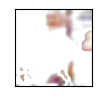

In [38]:
samp, lbl = dataiter_anomal.next()
lbl_np = lbl[0].cpu().numpy()
print(gtsrb_anomal_dm.idx2label[lbl_np.item()])
gtsrb_anomal_dm.unprocess_image(samp[0], plot=True)

## CIFAR-10 OoD

In [39]:
cifar10_dm = CIFAR10DataModule(data_dir=cifar10_data_path,
                               val_split=0.2,
                               num_workers=10,
                               normalize=True,
                               batch_size=1,
                               seed=10,
                               drop_last=True,
                               shuffle=True)

cifar10_transforms = transform_lib.Compose([
    transform_lib.Resize((128, 128)),
    transform_lib.ToTensor(),
    transform_lib.Normalize(
        mean=[0.3337, 0.3064, 0.3171],
        std=[0.2672, 0.2564, 0.2629]
    )
])

cifar10_dm.train_transforms = cifar10_transforms
cifar10_dm.test_transforms = cifar10_transforms
cifar10_dm.val_transforms  = cifar10_transforms

In [40]:
# cifar10_dm.prepare_data()

In [41]:
cifar10_dm.setup(stage='fit')
cifar10_dm.setup(stage='test')

In [42]:
cifar10_train_loader = cifar10_dm.train_dataloader()
cifar10_valid_loader = cifar10_dm.val_dataloader()
cifar10_test_loader = cifar10_dm.test_dataloader()
ic(len(cifar10_train_loader));
ic(len(cifar10_valid_loader));
ic(len(cifar10_test_loader));

ic| len(cifar10_train_loader): 40000
ic| len(cifar10_valid_loader): 10000
ic| len(cifar10_test_loader): 10000


In [43]:
def unprocess_cifar10_image(im,
                            norm_mean=[x / 255.0 for x in [125.3, 123.0, 113.9]],
                            norm_std=[x / 255.0 for x in [63.0, 62.1, 66.7]], 
                            plot=False):
    # im = im.squeeze().numpy().transpose((1, 2, 0))
    norm_mean = np.array(norm_mean)
    norm_std = np.array(norm_std)
    im = im.squeeze().numpy().transpose((1, 2, 0))
    im = norm_std * im + norm_mean
    im = np.clip(im, 0, 1)
    im = im * 255
    im = Image.fromarray(im.astype(np.uint8))

    if plot:
        plt.rcParams['figure.figsize'] = [2.54/2.54, 2.54/2.54]
        plt.imshow(im)
        plt.xticks([])
        plt.yticks([])
        plt.show()
    else:
        return im

In [44]:
dataiter = iter(cifar10_train_loader)

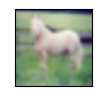

In [48]:
samp, lbl = dataiter.next()
lbl_np = lbl[0].cpu().numpy()
unprocess_cifar10_image(samp[0], norm_mean=[0.3337, 0.3064, 0.3171], norm_std=[0.2672, 0.2564, 0.2629], plot=True)

## STL-10 OoD

In [49]:
stl10_dm = STL10DataModule(data_dir=stl10_data_path,
                           train_val_split=3000,
                           num_workers=10,
                           batch_size=1,
                           seed=10,
                           drop_last=True,
                           shuffle=True)

stl10_transforms = transform_lib.Compose([
    transform_lib.Resize((128, 128)),
    transform_lib.ToTensor(),
    transform_lib.Normalize(
        mean=(0.3337, 0.3064, 0.3171),
        std=(0.2672, 0.2564, 0.2629)
    )
])

stl10_dm.train_transforms = stl10_transforms
stl10_dm.test_transforms = stl10_transforms
stl10_dm.val_transforms  = stl10_transforms

In [50]:
# stl10_dm.prepare_data()

In [51]:
stl10_train_loader = stl10_dm.train_dataloader_labeled()
stl10_valid_loader = stl10_dm.val_dataloader_labeled()
stl10_test_loader = stl10_dm.test_dataloader()
ic(len(stl10_train_loader));
ic(len(stl10_valid_loader));
ic(len(stl10_test_loader));

ic| len(stl10_train_loader): 2000
ic| len(stl10_valid_loader): 3000
ic| len(stl10_test_loader): 8000


In [52]:
def unprocess_stl10_image(im,
                          norm_mean=[0.43, 0.42, 0.39],
                          norm_std=[0.27, 0.26, 0.27], 
                          plot=False):

    norm_mean = np.array(norm_mean)
    norm_std = np.array(norm_std)
    im = im.squeeze().numpy().transpose((1, 2, 0))
    im = norm_std * im + norm_mean
    im = np.clip(im, 0, 1)
    im = im * 255
    im = Image.fromarray(im.astype(np.uint8))

    if plot:
        plt.rcParams['figure.figsize'] = [2.54/2.54, 2.54/2.54]
        plt.imshow(im)
        plt.xticks([])
        plt.yticks([])
        plt.show()
    else:
        return im

In [53]:
dataiter = iter(stl10_train_loader)

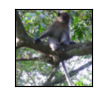

In [54]:
samp, lbl = dataiter.next()
lbl_np = lbl[0].cpu().numpy()
unprocess_stl10_image(samp[0], norm_mean=[0.3337, 0.3064, 0.3171], norm_std=[0.2672, 0.2564, 0.2629], plot=True)

# GTSRB ResNet18 Classifier

In [55]:
gtsrb_model = ResnetModule.load_from_checkpoint(checkpoint_path=gtsrb_resnet18_model_path)

In [56]:
gtsrb_model;

In [57]:
gtsrb_model.eval();

In [58]:
gtsrb_model.model.avgpool

AdaptiveAvgPool2d(output_size=(1, 1))

# Add Hook

We add 2 Hooks:

1. In the dropblock2d layer (after applying dropout to the)
2. In the fc (after applying a linear transformation to the output of the dropblock2d layer)

In [61]:
ic(gtsrb_model.model.dropblock2d_layer);
ic(gtsrb_model.model.dropblock2d_layer.drop_prob);
ic(gtsrb_model.model.dropblock2d_layer.block_size);
ic(gtsrb_model.model.dropblock2d_layer.training);
ic("===========================");

ic| gtsrb_model.model.dropblock2d_layer: DropBlock2D()
ic| gtsrb_model.model.dropblock2d_layer.drop_prob: 0.5
ic| gtsrb_model.model.dropblock2d_layer.block_size: 6
ic| gtsrb_model.model.dropblock2d_layer.training: False
ic| '==========================='


## Hook DropBlock2D Layer

In [62]:
gtsrb_model_dropblock2d_layer_hook = Hook(gtsrb_model.model.dropblock2d_layer)

In [63]:
ic(gtsrb_model.model.dropblock2d_layer._forward_hooks);

ic| gtsrb_model.model.dropblock2d_layer._forward_hooks: OrderedDict([(2,
                                                                      <bound method Hook.hook_fn of <ls_ood_detect_cea.uncertainty_estimation.Hook object at 0x7f65405cd690>>)])


# Get Monte-Carlo Samples

In [64]:
# Monte Carlo Dropout - Enable Dropout @ Test Time!
def resnet18_enable_dropblock2d_test(m):
    if type(m) == DropBlock2D:
        m.train()

In [65]:
mc_samples = 16

In [66]:
gtsrb_model.to(device);
gtsrb_model.eval(); 
gtsrb_model.apply(resnet18_enable_dropblock2d_test); # enable dropout

In [67]:
ic(gtsrb_model.model.dropblock2d_layer);
ic(gtsrb_model.model.dropblock2d_layer.drop_prob);
ic(gtsrb_model.model.dropblock2d_layer.block_size);
ic(gtsrb_model.model.dropblock2d_layer.training);
ic("=======");

ic| gtsrb_model.model.dropblock2d_layer: DropBlock2D()


ic| gtsrb_model.model.dropblock2d_layer.drop_prob: 0.5
ic| gtsrb_model.model.dropblock2d_layer.block_size: 6
ic| gtsrb_model.model.dropblock2d_layer.training: True
ic| '======='


In [68]:
gtsrb_resnet_gtsrb_normal_train_16mc_samples = get_latent_represent_mcd_samples(gtsrb_model.model,
                                                                                gtsrb_normal_train_loader,
                                                                                mc_samples,
                                                                                gtsrb_model_dropblock2d_layer_hook,
                                                                                get_2d_rep_mean=True)

In [69]:
gtsrb_resnet_gtsrb_normal_valid_16mc_samples = get_latent_represent_mcd_samples(gtsrb_model.model,
                                                                                gtsrb_normal_valid_loader,
                                                                                mc_samples,
                                                                                gtsrb_model_dropblock2d_layer_hook,
                                                                                get_2d_rep_mean=True)

In [70]:
gtsrb_resnet_gtsrb_normal_test_16mc_samples = get_latent_represent_mcd_samples(gtsrb_model.model,
                                                                               gtsrb_normal_test_loader,
                                                                               mc_samples,
                                                                               gtsrb_model_dropblock2d_layer_hook,
                                                                               get_2d_rep_mean=True)

In [71]:
gtsrb_resnet_gtsrb_anomal_valid_16mc_samples = get_latent_represent_mcd_samples(gtsrb_model.model,
                                                                                gtsrb_anomal_valid_loader,
                                                                                mc_samples,
                                                                                gtsrb_model_dropblock2d_layer_hook,
                                                                                get_2d_rep_mean=True)

In [72]:
gtsrb_resnet_gtsrb_anomal_test_16mc_samples = get_latent_represent_mcd_samples(gtsrb_model.model,
                                                                               gtsrb_anomal_test_loader,
                                                                               mc_samples,
                                                                               gtsrb_model_dropblock2d_layer_hook,
                                                                               get_2d_rep_mean=True)

In [73]:
gtsrb_resnet_cifar10_valid_16mc_samples = get_latent_represent_mcd_samples(gtsrb_model.model,
                                                                           cifar10_valid_loader,
                                                                           mc_samples,
                                                                           gtsrb_model_dropblock2d_layer_hook,
                                                                           get_2d_rep_mean=True)

In [74]:
gtsrb_resnet_cifar10_test_16mc_samples = get_latent_represent_mcd_samples(gtsrb_model.model,
                                                                          cifar10_test_loader,
                                                                          mc_samples,
                                                                          gtsrb_model_dropblock2d_layer_hook,
                                                                          get_2d_rep_mean=True)

In [75]:
gtsrb_resnet_stl10_valid_16mc_samples = get_latent_represent_mcd_samples(gtsrb_model.model,
                                                                         stl10_valid_loader,
                                                                         mc_samples,
                                                                         gtsrb_model_dropblock2d_layer_hook,
                                                                         get_2d_rep_mean=True)

In [76]:
gtsrb_resnet_stl10_test_16mc_samples = get_latent_represent_mcd_samples(gtsrb_model.model,
                                                                        stl10_test_loader,
                                                                        mc_samples,
                                                                        gtsrb_model_dropblock2d_layer_hook,
                                                                        get_2d_rep_mean=True)

In [77]:
mc_samples_path

'/media/farnez/Data/EXPERIMENTS/ICLR-2024/gtsrb-classification/resnet18_model_7/embeddings_z/mc_samples/'

In [78]:
torch.save(gtsrb_resnet_gtsrb_normal_train_16mc_samples,
           mc_samples_path + "gtsrb_resnet_gtsrb_normal_train_16mc_samples.pt")

In [79]:
torch.save(gtsrb_resnet_gtsrb_normal_valid_16mc_samples,
           mc_samples_path + 'gtsrb_resnet_gtsrb_normal_valid_16mc_samples.pt')
torch.save(gtsrb_resnet_gtsrb_normal_test_16mc_samples,
           mc_samples_path + 'gtsrb_resnet_gtsrb_normal_test_16mc_samples.pt')

In [80]:
torch.save(gtsrb_resnet_gtsrb_anomal_valid_16mc_samples,
           mc_samples_path + 'gtsrb_resnet_gtsrb_anomal_valid_16mc_samples.pt')
torch.save(gtsrb_resnet_gtsrb_anomal_test_16mc_samples,
           mc_samples_path + 'gtsrb_resnet_gtsrb_anomal_test_16mc_samples.pt')

In [81]:
torch.save(gtsrb_resnet_cifar10_valid_16mc_samples,
           mc_samples_path + 'gtsrb_resnet_cifar10_valid_16mc_samples.pt')
torch.save(gtsrb_resnet_cifar10_test_16mc_samples,
           mc_samples_path + 'gtsrb_resnet_cifar10_test_16mc_samples.pt')

In [82]:
torch.save(gtsrb_resnet_stl10_valid_16mc_samples,
           mc_samples_path + 'gtsrb_resnet_stl10_valid_16mc_samples.pt')
torch.save(gtsrb_resnet_stl10_test_16mc_samples,
           mc_samples_path + 'gtsrb_resnet_stl10_test_16mc_samples.pt')

# Get Entropy

In [83]:
_, gtsrb_rn18_h_z_gtsrb_normal_train_samples_np = get_dl_h_z(gtsrb_resnet_gtsrb_normal_train_16mc_samples, mcd_samples_nro=mc_samples)

ic| dl_h_mvn_z_samples_np.shape: (7120, 1)
ic| dl_h_z_samples_np.shape: (7120, 128)


In [84]:
_, gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np = get_dl_h_z(gtsrb_resnet_gtsrb_normal_valid_16mc_samples, mcd_samples_nro=mc_samples)

ic| dl_h_mvn_z_samples_np.shape: (3609, 1)
ic| dl_h_z_samples_np.shape: (3609, 128)


In [85]:
_, gtsrb_rn18_h_z_gtsrb_normal_test_samples_np = get_dl_h_z(gtsrb_resnet_gtsrb_normal_test_16mc_samples, mcd_samples_nro=mc_samples)

ic| dl_h_mvn_z_samples_np.shape: (1273, 1)
ic| dl_h_z_samples_np.shape: (1273, 128)


In [86]:
_, gtsrb_rn18_h_z_gtsrb_anomal_valid_samples_np = get_dl_h_z(gtsrb_resnet_gtsrb_anomal_valid_16mc_samples, mcd_samples_nro=mc_samples)

ic| dl_h_mvn_z_samples_np.shape: (3609, 1)
ic| dl_h_z_samples_np.shape: (3609, 128)


In [87]:
_, gtsrb_rn18_h_z_gtsrb_anomal_test_samples_np = get_dl_h_z(gtsrb_resnet_gtsrb_anomal_test_16mc_samples, mcd_samples_nro=mc_samples)

ic| dl_h_mvn_z_samples_np.shape: (1273, 1)
ic| dl_h_z_samples_np.shape: (1273, 128)


In [88]:
_, gtsrb_rn18_h_z_cifar10_valid_samples_np = get_dl_h_z(gtsrb_resnet_cifar10_valid_16mc_samples, mcd_samples_nro=mc_samples)

ic| dl_h_mvn_z_samples_np.shape: (10000, 1)
ic| dl_h_z_samples_np.shape: (10000, 128)


In [89]:
_, gtsrb_rn18_h_z_cifar10_test_samples_np = get_dl_h_z(gtsrb_resnet_cifar10_test_16mc_samples, mcd_samples_nro=mc_samples)

ic| dl_h_mvn_z_samples_np.shape: (10000, 1)
ic| dl_h_z_samples_np.shape: (10000, 128)


In [90]:
_, gtsrb_rn18_h_z_stl10_valid_samples_np = get_dl_h_z(gtsrb_resnet_stl10_valid_16mc_samples, mcd_samples_nro=mc_samples)

ic| dl_h_mvn_z_samples_np.shape: (3000, 1)
ic| dl_h_z_samples_np.shape: (3000, 128)


In [91]:
_, gtsrb_rn18_h_z_stl10_test_samples_np = get_dl_h_z(gtsrb_resnet_stl10_test_16mc_samples, mcd_samples_nro=mc_samples)

ic| dl_h_mvn_z_samples_np.shape: (8000, 1)
ic| dl_h_z_samples_np.shape: (8000, 128)


In [93]:
np.save(h_z_path + 'gtsrb_rn18_h_z_gtsrb_normal_train_samples_np',
        gtsrb_rn18_h_z_gtsrb_normal_train_samples_np)
np.save(h_z_path + 'gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np',
        gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np)
np.save(h_z_path + 'gtsrb_rn18_h_z_gtsrb_normal_test_samples_np',
        gtsrb_rn18_h_z_gtsrb_normal_test_samples_np)

np.save(h_z_path + 'gtsrb_rn18_h_z_gtsrb_anomal_valid_samples_np',
        gtsrb_rn18_h_z_gtsrb_anomal_valid_samples_np)
np.save(h_z_path + 'gtsrb_rn18_h_z_gtsrb_anomal_test_samples_np',
        gtsrb_rn18_h_z_gtsrb_anomal_test_samples_np)

np.save(h_z_path + 'gtsrb_rn18_h_z_cifar10_valid_samples_np',
        gtsrb_rn18_h_z_cifar10_valid_samples_np)
np.save(h_z_path + 'gtsrb_rn18_h_z_cifar10_test_samples_np',
        gtsrb_rn18_h_z_cifar10_test_samples_np)

np.save(h_z_path + 'gtsrb_rn18_h_z_stl10_valid_samples_np',
        gtsrb_rn18_h_z_stl10_valid_samples_np)
np.save(h_z_path + 'gtsrb_rn18_h_z_stl10_test_samples_np',
        gtsrb_rn18_h_z_stl10_test_samples_np)

# Load Entropy Values

In [94]:
gtsrb_rn18_h_z_gtsrb_normal_train_samples_np = np.load(h_z_path + 'gtsrb_rn18_h_z_gtsrb_normal_train_samples_np.npy')
gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np = np.load(h_z_path + 'gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np.npy')
gtsrb_rn18_h_z_gtsrb_normal_test_samples_np = np.load(h_z_path + 'gtsrb_rn18_h_z_gtsrb_normal_test_samples_np.npy')

gtsrb_rn18_h_z_gtsrb_anomal_valid_samples_np = np.load(h_z_path + 'gtsrb_rn18_h_z_gtsrb_anomal_valid_samples_np.npy')
gtsrb_rn18_h_z_gtsrb_anomal_test_samples_np = np.load(h_z_path + 'gtsrb_rn18_h_z_gtsrb_anomal_test_samples_np.npy')

gtsrb_rn18_h_z_cifar10_valid_samples_np = np.load(h_z_path + 'gtsrb_rn18_h_z_cifar10_valid_samples_np.npy')
gtsrb_rn18_h_z_cifar10_test_samples_np = np.load(h_z_path + 'gtsrb_rn18_h_z_cifar10_test_samples_np.npy')

gtsrb_rn18_h_z_stl10_valid_samples_np = np.load(h_z_path + 'gtsrb_rn18_h_z_stl10_valid_samples_np.npy')
gtsrb_rn18_h_z_stl10_test_samples_np = np.load(h_z_path + 'gtsrb_rn18_h_z_stl10_test_samples_np.npy')

In [95]:
ic(gtsrb_rn18_h_z_gtsrb_normal_train_samples_np.shape);
ic(gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np.shape);
ic(gtsrb_rn18_h_z_gtsrb_normal_test_samples_np.shape);
ic(gtsrb_rn18_h_z_gtsrb_anomal_valid_samples_np.shape);
ic(gtsrb_rn18_h_z_gtsrb_anomal_test_samples_np.shape);
ic(gtsrb_rn18_h_z_cifar10_valid_samples_np.shape);
ic(gtsrb_rn18_h_z_cifar10_test_samples_np.shape);
ic(gtsrb_rn18_h_z_stl10_valid_samples_np.shape);
ic(gtsrb_rn18_h_z_stl10_test_samples_np.shape);


ic| gtsrb_rn18_h_z_gtsrb_normal_train_samples_np.shape: (7120, 128)


ic| gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np.shape: (3609, 128)
ic| gtsrb_rn18_h_z_gtsrb_normal_test_samples_np.shape: (1273, 128)
ic| gtsrb_rn18_h_z_gtsrb_anomal_valid_samples_np.shape: (3609, 128)
ic| gtsrb_rn18_h_z_gtsrb_anomal_test_samples_np.shape: (1273, 128)
ic| gtsrb_rn18_h_z_cifar10_valid_samples_np.shape: (10000, 128)
ic| gtsrb_rn18_h_z_cifar10_test_samples_np.shape: (10000, 128)
ic| gtsrb_rn18_h_z_stl10_valid_samples_np.shape: (3000, 128)
ic| gtsrb_rn18_h_z_stl10_test_samples_np.shape: (8000, 128)
